# Proof of Concept (PoC)

Building QMARL with entangled agents.

In [29]:
import cirq
import matplotlib.gridspec as gsp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
## Functions to create various entangled input states.

def entangle_agents_phi_plus(qubits, d: int, n: int):
    """Entangles via $\\phi+$."""

    # Entangle the input qubits.
    for i in range(d):
        yield cirq.H(qubits[i])
        for j in range(n-1):
            yield cirq.CNOT(qubits[j*d + i], qubits[(j+1)*d + i])


def entangle_agents_psi_plus(qubits, d: int, n: int):
    """Entangles via $\\psi+$."""

    # Entangle the input qubits.
    for i in range(d):
        yield cirq.H(qubits[i])
        for j in range(n-1):
            yield cirq.X(qubits[(j+1)*d + i])
            yield cirq.CNOT(qubits[j*d + i], qubits[(j+1)*d + i])

In [3]:
def agent_policy(qubits, d: int, aidx: int, thetas: np.ndarray = None, return_thetas: bool = False):
    """Agent RL policy circuit."""
    
    if thetas is None:
        thetas = np.random.uniform(low=0., high=np.pi, size=(d, 3,))
    
    def yield_circuit():
        for i in range(d):
            yield [
                cirq.Rx(rads=thetas[i][0])(qubits[aidx*d + i]),
                cirq.Ry(rads=thetas[i][1])(qubits[aidx*d + i]),
                cirq.Rz(rads=thetas[i][2])(qubits[aidx*d + i]),
                ]
        for i in range(d-1):
            yield cirq.CNOT(qubits[aidx*d + i], qubits[aidx*d + i + 1])
            
    if return_thetas:
        return yield_circuit(), thetas
    else:
        return yield_circuit()

In [22]:
def measure_agent(qubits, d: int, aidx: int, key_prefix: str = 'agent'):
    """Apply a measurement on the qubits associated with a specific agent.
    
    By default, the measurement will have the key string `'agent{aidx}'` where `aidx` is the provided agent index.
    """
    qidx = aidx * d # Starting qubit index for the specified agent.
    return cirq.measure(qubits[qidx:qidx+d], key=f"{key_prefix}{aidx}")

In [4]:
d_qubits = 2 # Number of qubits (dimension) for each agent.
n_agents = 2 # Number of agents.

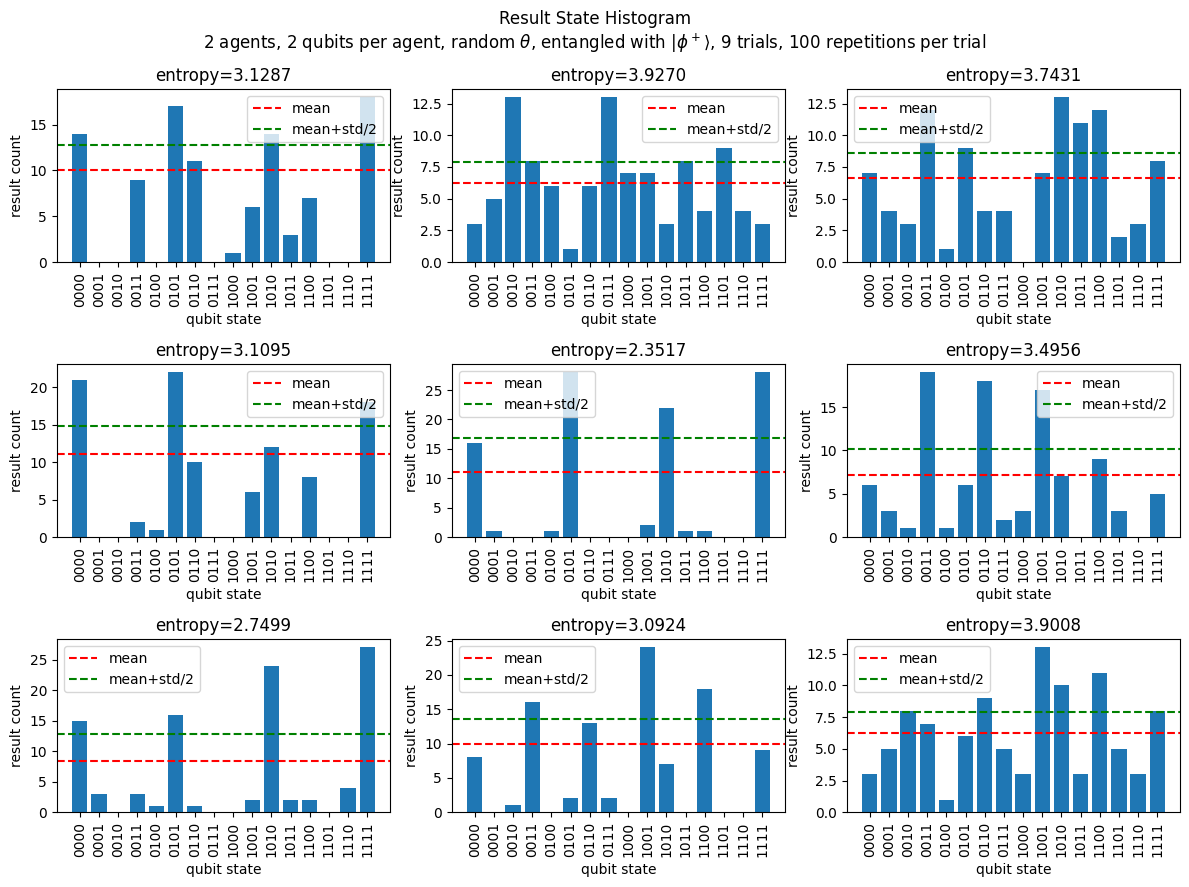

In [33]:

def test_entangled_phi_plus(d: int, n: int, repetitions: int = 100):

    qubits = cirq.LineQubit.range(d * n)


    fig, axs = plt.subplots(3, 3, figsize=(12, 9))
    axs = axs.flatten()
    n_circuits = len(axs)
    fig.suptitle(f'Result State Histogram\n{n} agents, {d} qubits per agent, random $\\theta$, entangled with $|\phi^+\\rangle$, {len(axs)} trials, {repetitions} repetitions per trial')

    sim = cirq.Simulator()

    for i in range(n_circuits):
        circuit = cirq.Circuit()
        circuit.append(entangle_agents_phi_plus(qubits, d, n))
        for aidx in range(n):
            circuit.append(agent_policy(qubits, d, aidx))
        circuit.append(cirq.measure(qubits, key='actions'))
        
        rho = cirq.final_density_matrix(circuit)
        entropy = cirq.von_neumann_entropy(rho)
        
        samples = sim.run(circuit, repetitions=repetitions)

        cirq.plot_state_histogram(samples, axs[i])
        ctr = samples.histogram(key='actions')
        mean = np.mean([v for k, v in ctr.items()])
        std = np.std([v for k, v in ctr.items()])
        axs[i].axhline(y=mean, color='r', linestyle='--', label='mean')
        axs[i].axhline(y=mean+std/2., color='g', linestyle='--', label='mean+std/2')
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
        axs[i].xaxis.set_major_formatter(lambda x, pos: f"{int(x):0{d*n}b}")
        axs[i].legend()
        axs[i].set_title(f"{entropy=:.4f}")

    fig.tight_layout()
    return fig


test_entangled_phi_plus(d_qubits, n_agents);

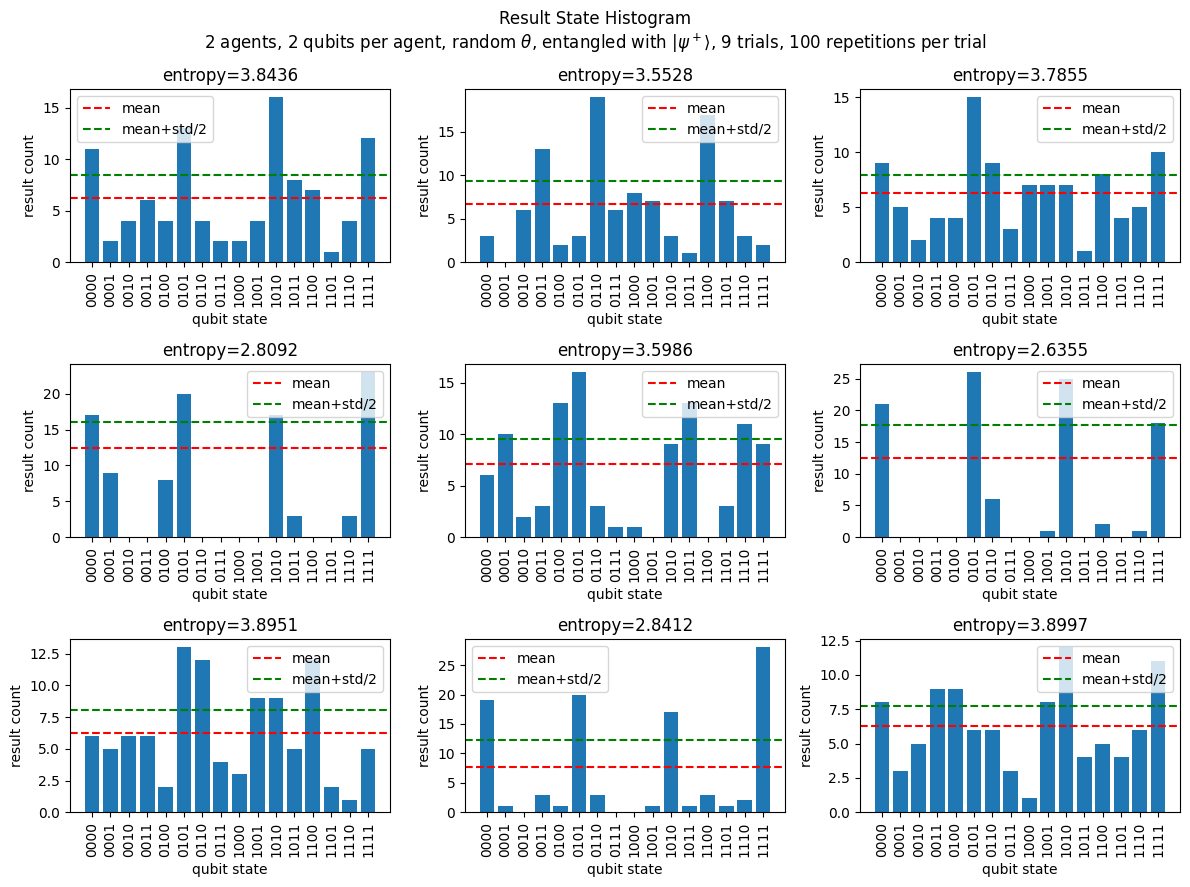

In [25]:

def test_entangled_psi_plus(d: int, n: int, repetitions: int = 100):

    qubits = cirq.LineQubit.range(d * n)


    fig, axs = plt.subplots(3, 3, figsize=(12, 9))
    axs = axs.flatten()
    n_circuits = len(axs)
    fig.suptitle(f'Result State Histogram\n{n} agents, {d} qubits per agent, random $\\theta$, entangled with $|\psi^+\\rangle$, {len(axs)} trials, {repetitions} repetitions per trial')

    sim = cirq.Simulator()

    for i in range(n_circuits):
        circuit = cirq.Circuit()
        circuit.append(entangle_agents_psi_plus(qubits, d, n))
        for aidx in range(n):
            circuit.append(agent_policy(qubits, d, aidx))
        circuit.append(cirq.measure(qubits, key='actions'))
        
        rho = cirq.final_density_matrix(circuit)
        entropy = cirq.von_neumann_entropy(rho)
        
        samples = sim.run(circuit, repetitions=repetitions)

        cirq.plot_state_histogram(samples, axs[i])
        ctr = samples.histogram(key='actions')
        mean = np.mean([v for k, v in ctr.items()])
        std = np.std([v for k, v in ctr.items()])
        axs[i].axhline(y=mean, color='r', linestyle='--', label='mean')
        axs[i].axhline(y=mean+std/2., color='g', linestyle='--', label='mean+std/2')
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
        axs[i].xaxis.set_major_formatter(lambda x, pos: f"{int(x):0{d*n}b}")
        axs[i].legend()
        axs[i].set_title(f"{entropy=:.4f}")

    fig.tight_layout()
    return fig


test_entangled_psi_plus(d_qubits, n_agents);

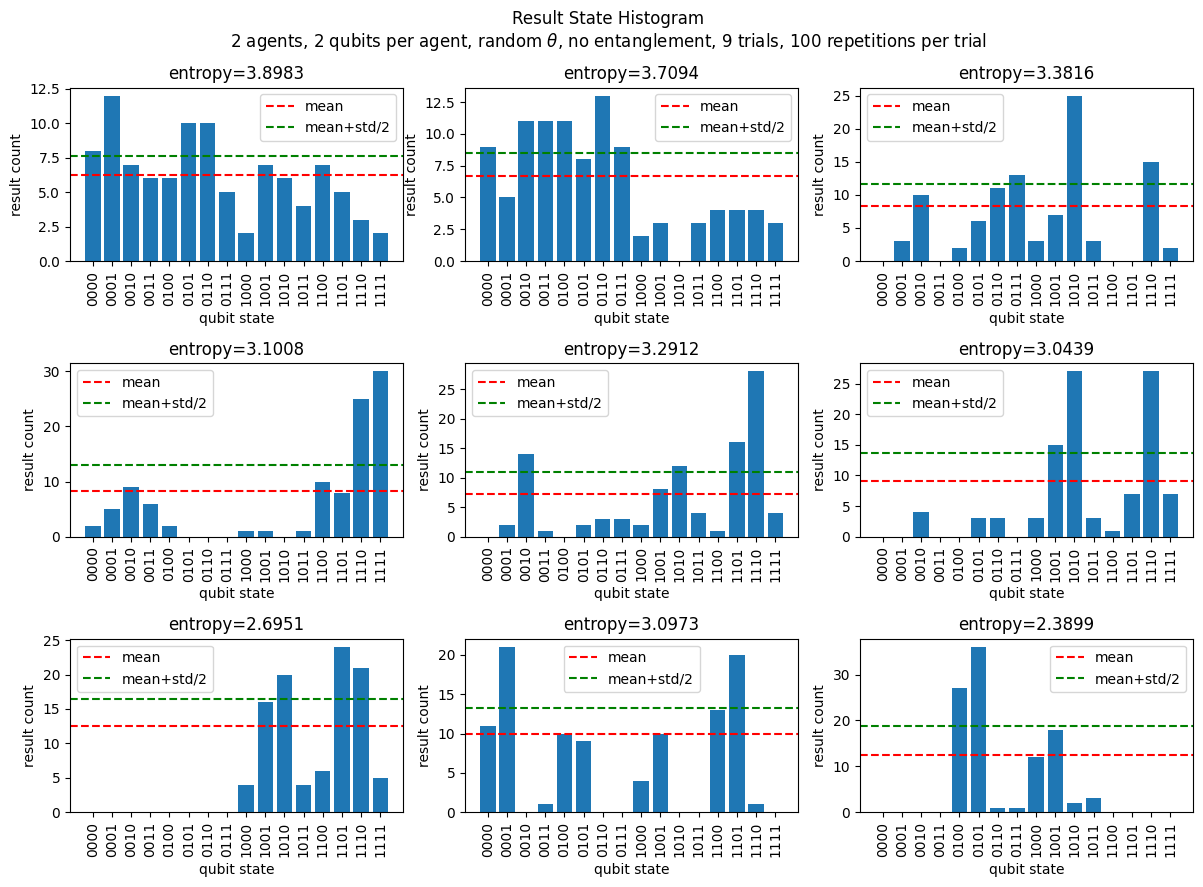

In [31]:

def test_no_entangled(d: int, n: int, repetitions: int = 100):

    qubits = cirq.LineQubit.range(d * n)


    fig, axs = plt.subplots(3, 3, figsize=(12, 9))
    axs = axs.flatten()
    n_circuits = len(axs)
    fig.suptitle(f'Result State Histogram\n{n} agents, {d} qubits per agent, random $\\theta$, no entanglement, {len(axs)} trials, {repetitions} repetitions per trial')

    sim = cirq.Simulator()

    for i in range(n_circuits):
        circuit = cirq.Circuit()
        for aidx in range(n):
            circuit.append(agent_policy(qubits, d, aidx))
        circuit.append(cirq.measure(qubits, key='actions'))
        
        rho = cirq.final_density_matrix(circuit)
        entropy = cirq.von_neumann_entropy(rho)
        
        samples = sim.run(circuit, repetitions=repetitions)

        cirq.plot_state_histogram(samples, axs[i])
        ctr = samples.histogram(key='actions')
        mean = np.mean([v for k, v in ctr.items()])
        std = np.std([v for k, v in ctr.items()])
        axs[i].axhline(y=mean, color='r', linestyle='--', label='mean')
        axs[i].axhline(y=mean+std/2., color='g', linestyle='--', label='mean+std/2')
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
        axs[i].xaxis.set_major_formatter(lambda x, pos: f"{int(x):0{d*n}b}")
        axs[i].legend()
        axs[i].set_title(f"{entropy=:.4f}")

    fig.tight_layout()
    return fig


test_no_entangled(d_qubits, n_agents);

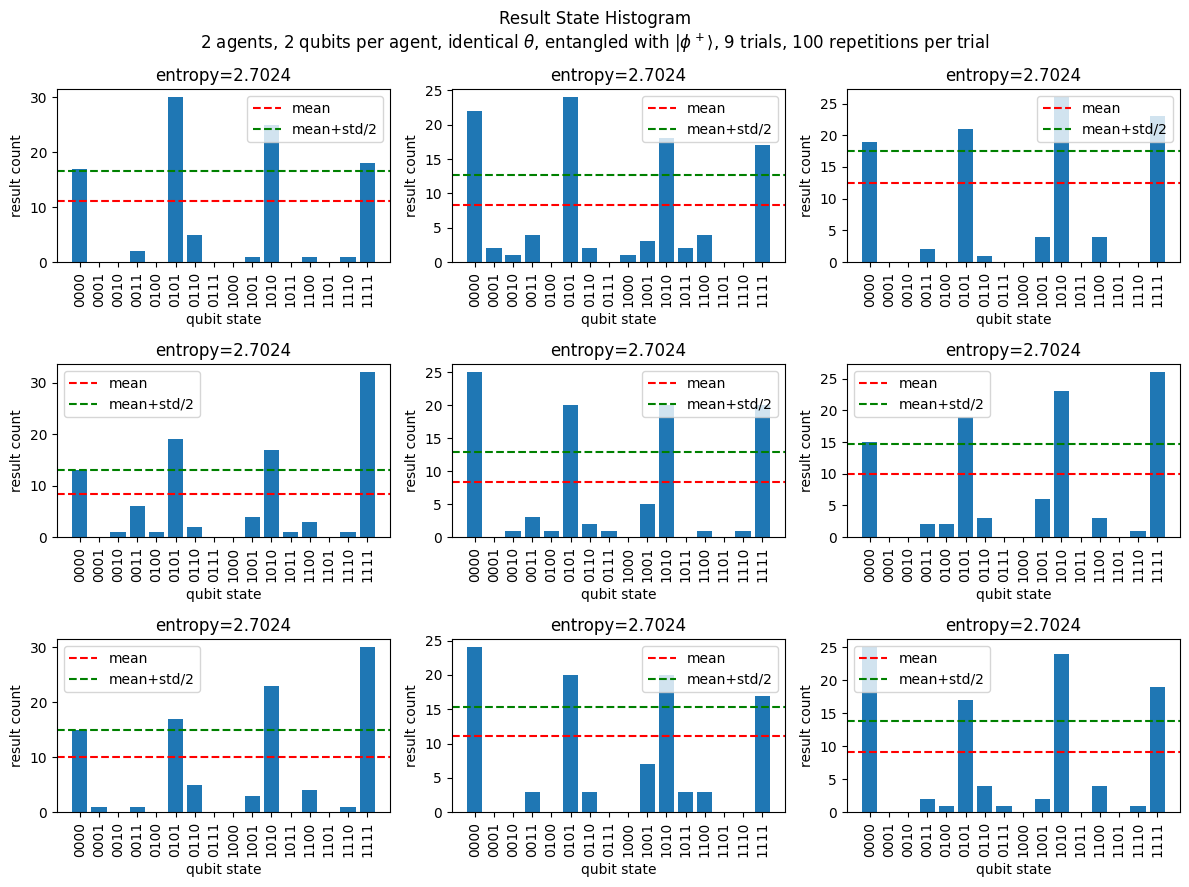

In [36]:

def test_entangled_phi_plus_identical_thetas(d: int, n: int, repetitions: int = 100):

    qubits = cirq.LineQubit.range(d * n)


    fig, axs = plt.subplots(3, 3, figsize=(12, 9))
    axs = axs.flatten()
    n_circuits = len(axs)
    fig.suptitle(f'Result State Histogram\n{n} agents, {d} qubits per agent, identical $\\theta$, entangled with $|\phi^+\\rangle$, {len(axs)} trials, {repetitions} repetitions per trial')

    sim = cirq.Simulator()
    
    thetas = np.random.uniform(low=0., high=np.pi, size=(d, 3,))

    for i in range(n_circuits):
        circuit = cirq.Circuit()
        circuit.append(entangle_agents_phi_plus(qubits, d, n))
        for aidx in range(n):
            circuit.append(agent_policy(qubits, d, aidx, thetas=thetas))
        circuit.append(cirq.measure(qubits, key='actions'))
        
        rho = cirq.final_density_matrix(circuit)
        entropy = cirq.von_neumann_entropy(rho)
        
        samples = sim.run(circuit, repetitions=repetitions)

        cirq.plot_state_histogram(samples, axs[i])
        ctr = samples.histogram(key='actions')
        mean = np.mean([v for k, v in ctr.items()])
        std = np.std([v for k, v in ctr.items()])
        axs[i].axhline(y=mean, color='r', linestyle='--', label='mean')
        axs[i].axhline(y=mean+std/2., color='g', linestyle='--', label='mean+std/2')
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
        axs[i].xaxis.set_major_formatter(lambda x, pos: f"{int(x):0{d*n}b}")
        axs[i].legend()
        axs[i].set_title(f"{entropy=:.4f}")

    fig.tight_layout()
    return fig


test_entangled_phi_plus_identical_thetas(d_qubits, n_agents);

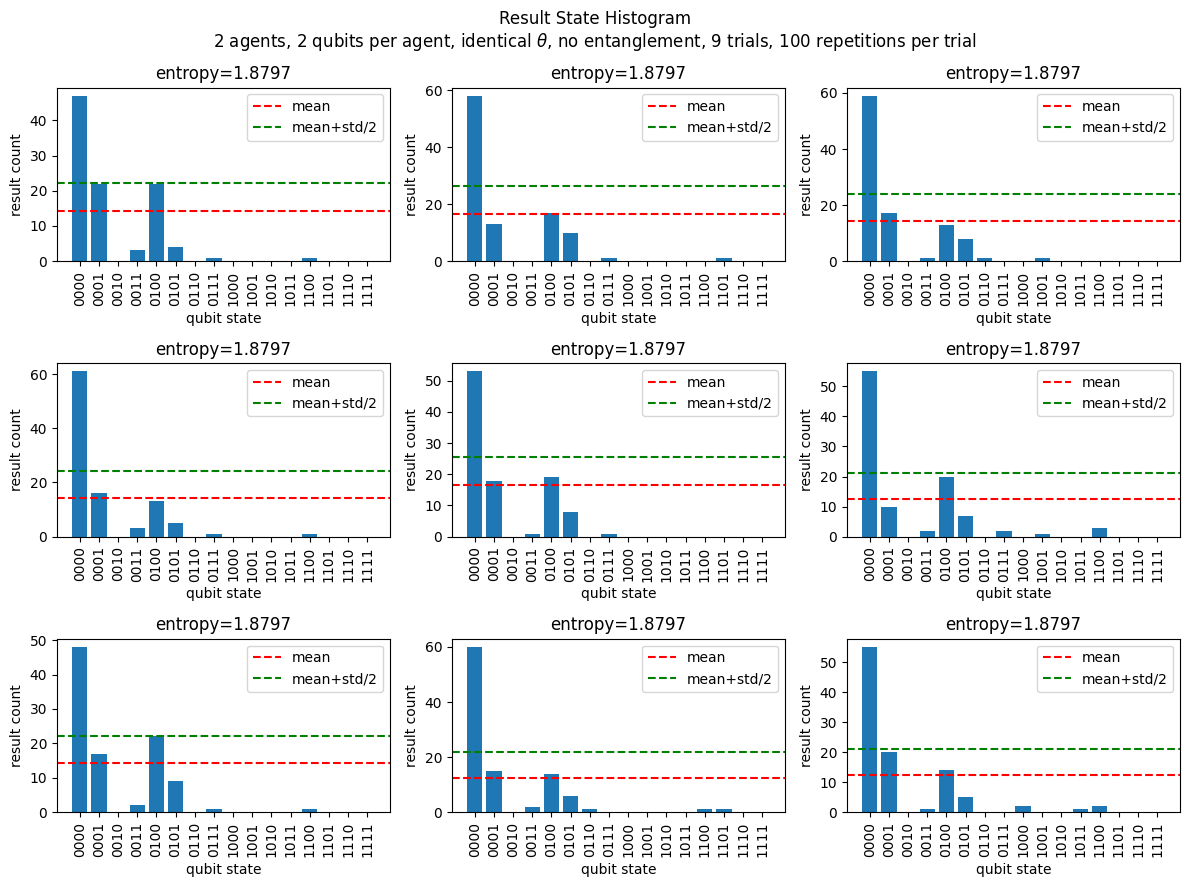

In [35]:

def test_no_entangled_identical_thetas(d: int, n: int, repetitions: int = 100):

    qubits = cirq.LineQubit.range(d * n)


    fig, axs = plt.subplots(3, 3, figsize=(12, 9))
    axs = axs.flatten()
    n_circuits = len(axs)
    fig.suptitle(f'Result State Histogram\n{n} agents, {d} qubits per agent, identical $\\theta$, no entanglement, {len(axs)} trials, {repetitions} repetitions per trial')

    sim = cirq.Simulator()
    
    thetas = np.random.uniform(low=0., high=np.pi, size=(d, 3,))

    for i in range(n_circuits):
        circuit = cirq.Circuit()
        # circuit.append(entangle_agents_phi_plus(qubits, d, n))
        for aidx in range(n):
            circuit.append(agent_policy(qubits, d, aidx, thetas=thetas))
        circuit.append(cirq.measure(qubits, key='actions'))
        
        rho = cirq.final_density_matrix(circuit)
        entropy = cirq.von_neumann_entropy(rho)
        
        samples = sim.run(circuit, repetitions=repetitions)

        cirq.plot_state_histogram(samples, axs[i])
        ctr = samples.histogram(key='actions')
        mean = np.mean([v for k, v in ctr.items()])
        std = np.std([v for k, v in ctr.items()])
        axs[i].axhline(y=mean, color='r', linestyle='--', label='mean')
        axs[i].axhline(y=mean+std/2., color='g', linestyle='--', label='mean+std/2')
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
        axs[i].xaxis.set_major_formatter(lambda x, pos: f"{int(x):0{d*n}b}")
        axs[i].legend()
        axs[i].set_title(f"{entropy=:.4f}")

    fig.tight_layout()
    return fig


test_no_entangled_identical_thetas(d_qubits, n_agents);

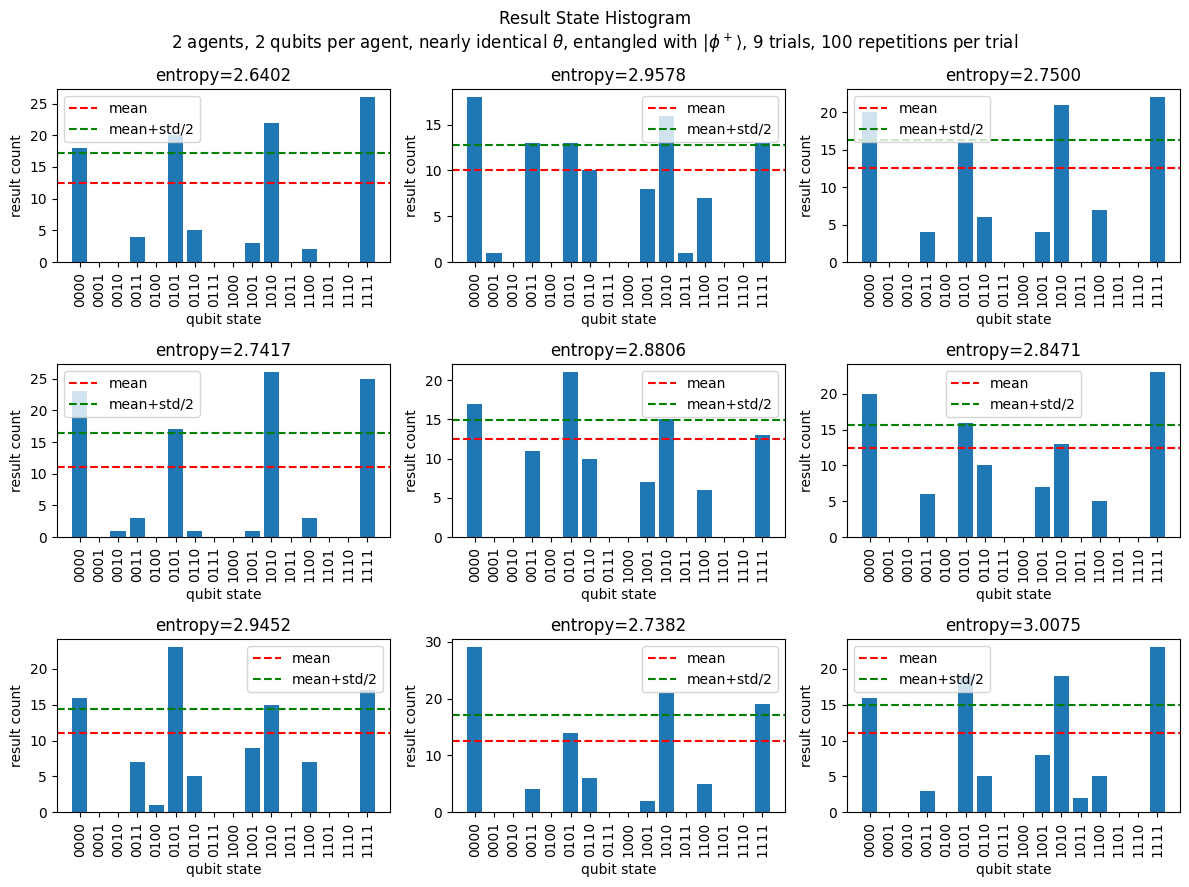

In [39]:

def test_entangled_phi_plus_approx_thetas(d: int, n: int, repetitions: int = 100):

    qubits = cirq.LineQubit.range(d * n)


    fig, axs = plt.subplots(3, 3, figsize=(12, 9))
    axs = axs.flatten()
    n_circuits = len(axs)
    fig.suptitle(f'Result State Histogram\n{n} agents, {d} qubits per agent, nearly identical $\\theta$, entangled with $|\psi^+\\rangle$, {len(axs)} trials, {repetitions} repetitions per trial')

    sim = cirq.Simulator()
    
    thetas = np.random.uniform(low=0., high=np.pi, size=(d, 3,))

    for i in range(n_circuits):
        circuit = cirq.Circuit()
        # circuit.append(entangle_agents_phi_plus(qubits, d, n))
        circuit.append(entangle_agents_psi_plus(qubits, d, n))
        for aidx in range(n):
            thetas_offset = np.random.uniform(low=0., high=0.5, size=(d, 3,))
            circuit.append(agent_policy(qubits, d, aidx, thetas=thetas+thetas_offset))
        circuit.append(cirq.measure(qubits, key='actions'))
        
        rho = cirq.final_density_matrix(circuit)
        entropy = cirq.von_neumann_entropy(rho)
        
        samples = sim.run(circuit, repetitions=repetitions)

        cirq.plot_state_histogram(samples, axs[i])
        ctr = samples.histogram(key='actions')
        mean = np.mean([v for k, v in ctr.items()])
        std = np.std([v for k, v in ctr.items()])
        axs[i].axhline(y=mean, color='r', linestyle='--', label='mean')
        axs[i].axhline(y=mean+std/2., color='g', linestyle='--', label='mean+std/2')
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
        axs[i].xaxis.set_major_formatter(lambda x, pos: f"{int(x):0{d*n}b}")
        axs[i].legend()
        axs[i].set_title(f"{entropy=:.4f}")

    fig.tight_layout()
    return fig


test_entangled_phi_plus_approx_thetas(d_qubits, n_agents);

/var/folders/5k/47hxnf0d2v1cvrggbx8z9ts40000gn/T/ipykernel_8161/2447199334.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/5k/47hxnf0d2v1cvrggbx8z9ts40000gn/T/ipykernel_8161/2447199334.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start wit

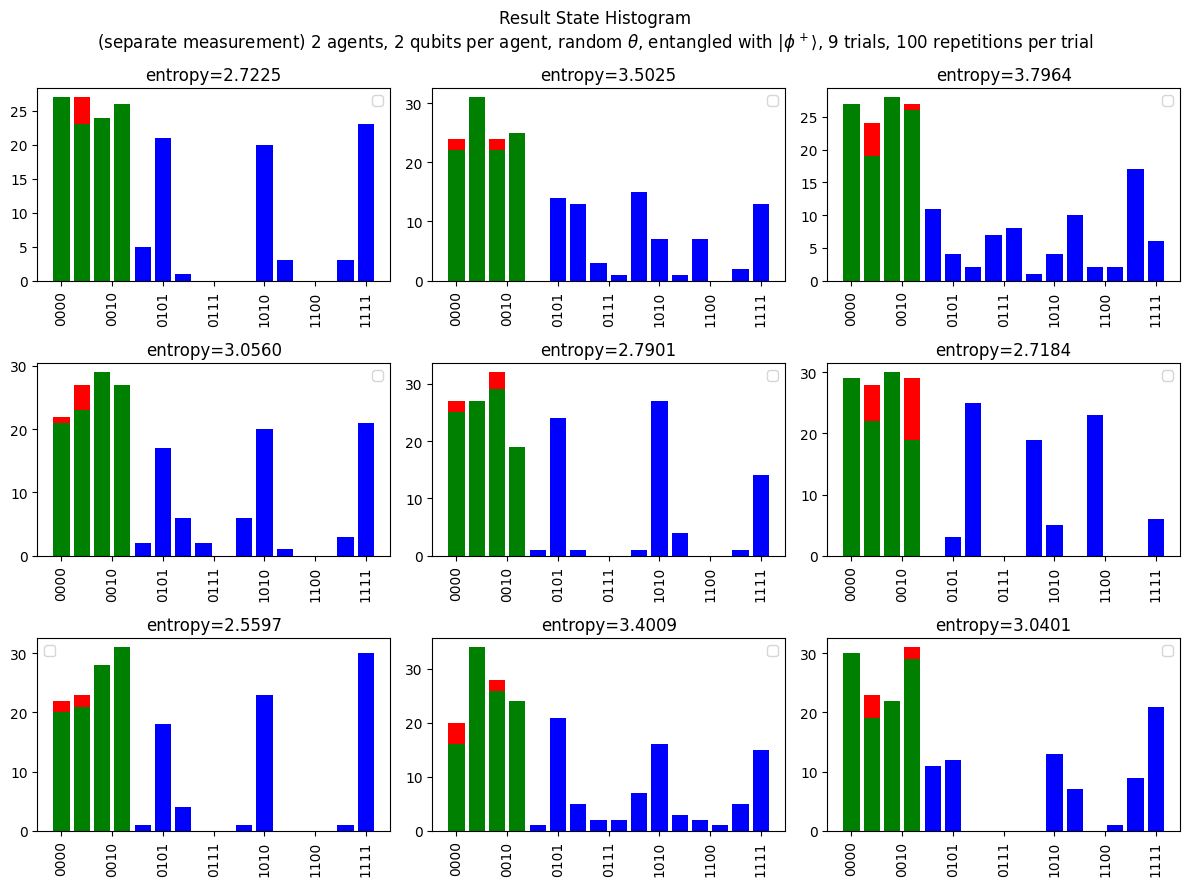

In [18]:
## Try separate measurements for each agent.

def test_entangled_phi_plus_separate_measurement(d: int, n: int, repetitions: int = 100):

    qubits = cirq.LineQubit.range(d * n)

    w, h = 3, 3
    fig, axs = plt.subplots(w, h, figsize=(12, 9))
    mosaic = """
    
    """
    fig, axs = plt.subplot_mosaic("""
                                  """)
    axs = axs.flatten()
    n_trials = w * h
    
    
    # fig = plt.figure(figsize=(12, 9))
    # grid_outer = gsp.GridSpec(w, h, figure=fig, wspace=0.2, hspace=0.2)
    
    
    fig.suptitle(f'Result State Histogram\n(separate measurement) {n} agents, {d} qubits per agent, random $\\theta$, entangled with $|\phi^+\\rangle$, {n_trials} trials, {repetitions} repetitions per trial')

    sim = cirq.Simulator()

    for i in range(n_trials):
        circuit = cirq.Circuit()
        circuit.append(entangle_agents_phi_plus(qubits, d, n))
        for aidx in range(n):
            circuit.append(agent_policy(qubits, d, aidx))
        circuit.append(cirq.measure(qubits, key='actions'))
        circuit.append(cirq.measure(qubits[:n], key='agent0'))
        circuit.append(cirq.measure(qubits[n:], key='agent1'))
        
        rho = cirq.final_density_matrix(circuit)
        entropy = cirq.von_neumann_entropy(rho)
        
        samples = sim.run(circuit, repetitions=repetitions)
        
        # grid_inner = gsp.GridSpecFromSubplotSpec(1, n, subplot_spec=grid_outer[i], wspace=0.1, hspace=0.1)

        for j in range(n):
            
            # ax = plt.Subplot(fig, grid_inner[j])
            
            hist_all = samples.histogram(key='actions')
            axs[i].bar(hist_all.keys(), hist_all.values(), color='blue')
            
            hist_agents = [samples.histogram(key=f"agent{k}") for k in range(n)]
            
            axs[i].bar(hist_agents[0].keys(), hist_agents[0].values(), color='red')
            axs[i].bar(hist_agents[1].keys(), hist_agents[1].values(), color='green')
            
            # hist = samples.histogram(key=f"agent{j}")
            # plt.hist()
            # cirq.plot_state_histogram(hist, axs[i], label=f"agent{j}")
            # ctr = samples.histogram(key='actions')
            # mean = np.mean([v for k, v in ctr.items()])
            # std = np.std([v for k, v in ctr.items()])
            # axs[i].axhline(y=mean, color='r', linestyle='--', label='mean')
            # axs[i].axhline(y=mean+std/2., color='g', linestyle='--', label='mean+std/2')
            axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
            axs[i].xaxis.set_major_formatter(lambda x, pos: f"{int(x):0{d*n}b}")
            axs[i].legend()
            axs[i].set_title(f"{entropy=:.4f}")

    fig.tight_layout()
    return fig


test_entangled_phi_plus_separate_measurement(d_qubits, n_agents);

In [9]:
fig = plt.figure(figsize=(12, 9))
grid_outer = gsp.GridSpec(3, 3, figure=fig, wspace=0.2, hspace=0.2)
len(grid_outer)

TypeError: object of type 'GridSpec' has no len()

<Figure size 1200x900 with 0 Axes>

In [115]:
def plot_state_histogram_all(samples, axis, d: int, n: int, key: str = 'all'):
    hist_all = samples.histogram(key=key)
    df_hist_all = pd.DataFrame.from_records([hist_all], columns=list(range(2**(d*n)))).melt(value_vars=list(range(2**(d*n)))).rename(columns={'variable': 'qubit state', 'value': 'result count'})
    sns.barplot(df_hist_all, x='qubit state', y='result count', ax=axis)
    axis.set_xticklabels(axis.get_xticklabels(), rotation=90)
    axis.xaxis.set_major_formatter(lambda x, pos: f"{int(x):0{d*n}b}")
    axis.legend()
    return axis


def plot_state_histogram_agents(samples, axis, d: int, n: int, key_prefix: str = 'agent'):
    hist_agents = [samples.histogram(key=f"{key_prefix}{k}") for k in range(n)]
    df_hist_agents = pd.DataFrame.from_records(hist_agents, columns=list(range(2**d)))
    df_hist_agents = df_hist_agents\
        .rename_axis(index='agent')\
        .reset_index()\
        .melt(id_vars='agent', value_vars=list(range(2**d)))\
        .rename(columns={'variable': 'qubit state', 'value': 'result count'})
    # df_hist_agents = df_hist_agents.apply(lambda L: f"agent{L['agent']}", axis=1)
    # df_hist_agents['agent'] = "agent" + df_hist_agents['agent'].astype(str)
    # print(df_hist_agents)

    sns.barplot(df_hist_agents, x='qubit state', y='result count', hue='agent', ax=axis)

    axis.set_xticklabels(axis.get_xticklabels(), rotation=90)
    axis.xaxis.set_major_formatter(lambda x, pos: f"{int(x):0{d}b}")
    # axis.legend(labels=[f"agent{aidx}" for aidx in range(n)])
    
    return axis

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


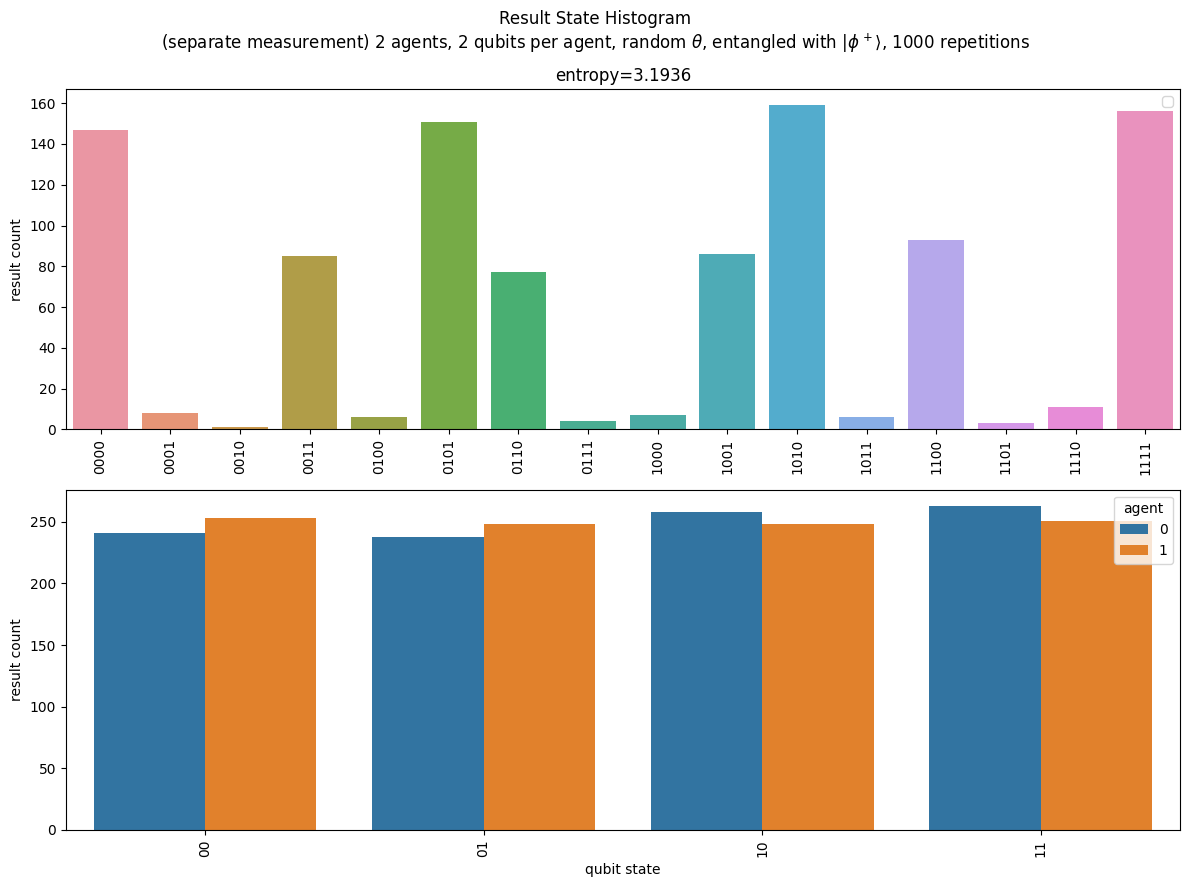

In [120]:
## Try separate measurements for each agent.

def test(d: int, n: int, repetitions: int = 100):

    qubits = cirq.LineQubit.range(d * n)

    w, h = 1, 2
    # fig, axs = plt.subplots(w, h, figsize=(12, 9))
    fig, axd = plt.subplot_mosaic(mosaic="A;B", figsize=(12, 9), layout='constrained')
    # axs = axs.flatten()
    
    # fig = plt.figure(figsize=(12, 9))
    # grid_outer = gsp.GridSpec(w, h, figure=fig, wspace=0.2, hspace=0.2)
    
    
    fig.suptitle(f'Result State Histogram\n(separate measurement) {n} agents, {d} qubits per agent, random $\\theta$, entangled with $|\phi^+\\rangle$, {repetitions} repetitions')

    sim = cirq.Simulator()

    circuit = cirq.Circuit()
    circuit.append(entangle_agents_phi_plus(qubits, d, n))
    for aidx in range(n):
        circuit.append(agent_policy(qubits, d, aidx)) # Policy circuit.
        circuit.append(measure_agent(qubits, d, aidx)) # Measure agent qubits.
    circuit.append(cirq.measure(qubits, key='all')) # Store measurement of entire system (all agents, for bookkeeping purposes).
    
    
    # print(circuit)
    
    rho = cirq.final_density_matrix(circuit)
    entropy = cirq.von_neumann_entropy(rho)
    
    samples = sim.run(circuit, repetitions=repetitions)

    plot_state_histogram_all(samples, axd['A'], d, n, key='all')
    plot_state_histogram_agents(samples, axd['B'], d, n, key_prefix='agent')

    axd['A'].set_title(f"{entropy=:.4f}")
    axd['A'].set_xlabel('')

    fig.tight_layout()

test(d_qubits, n_agents, repetitions=1000);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


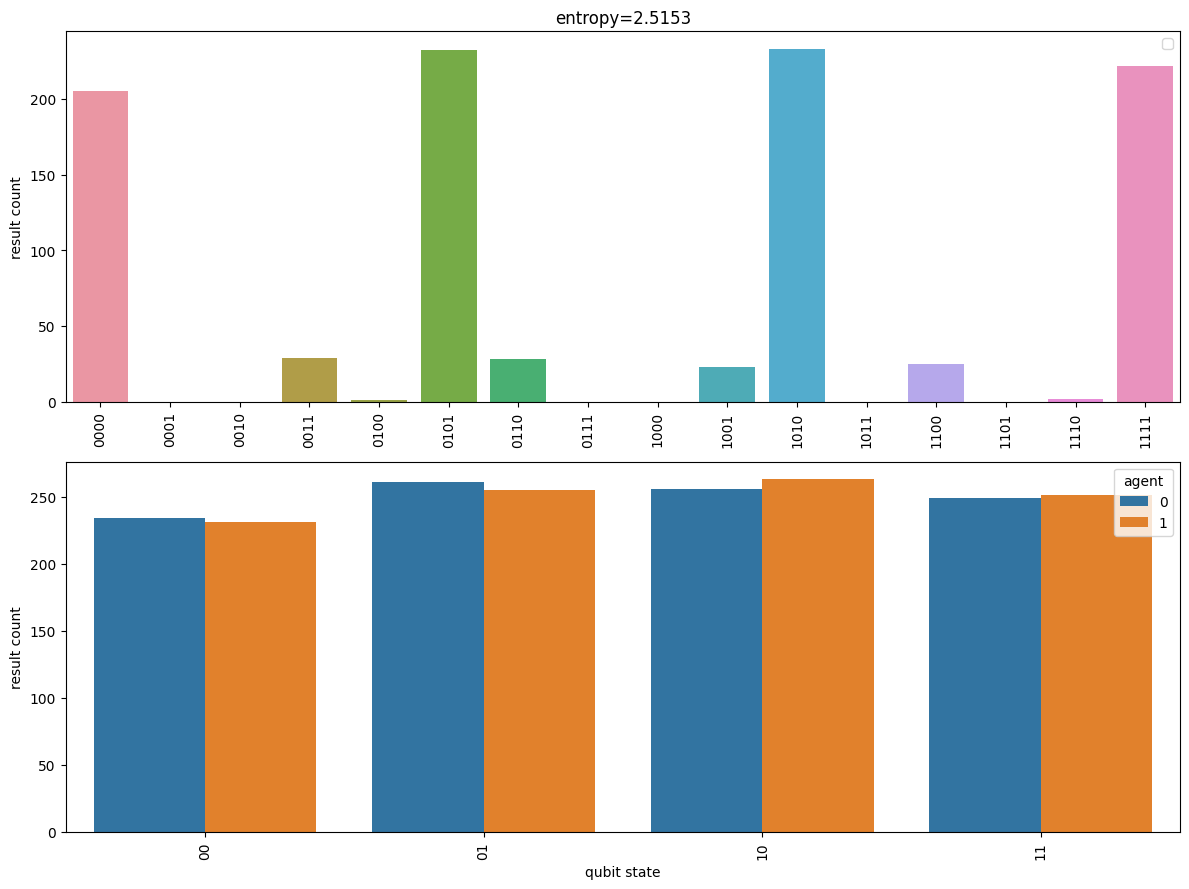

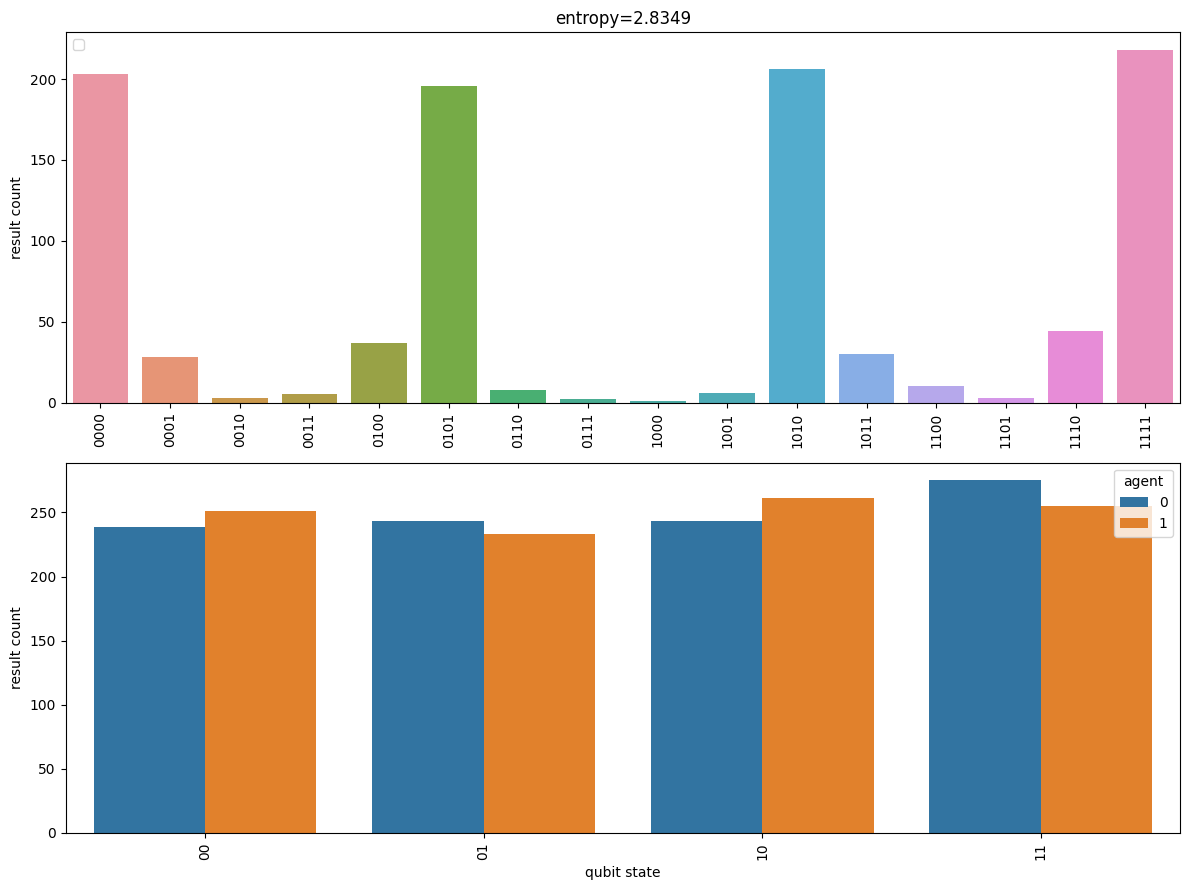

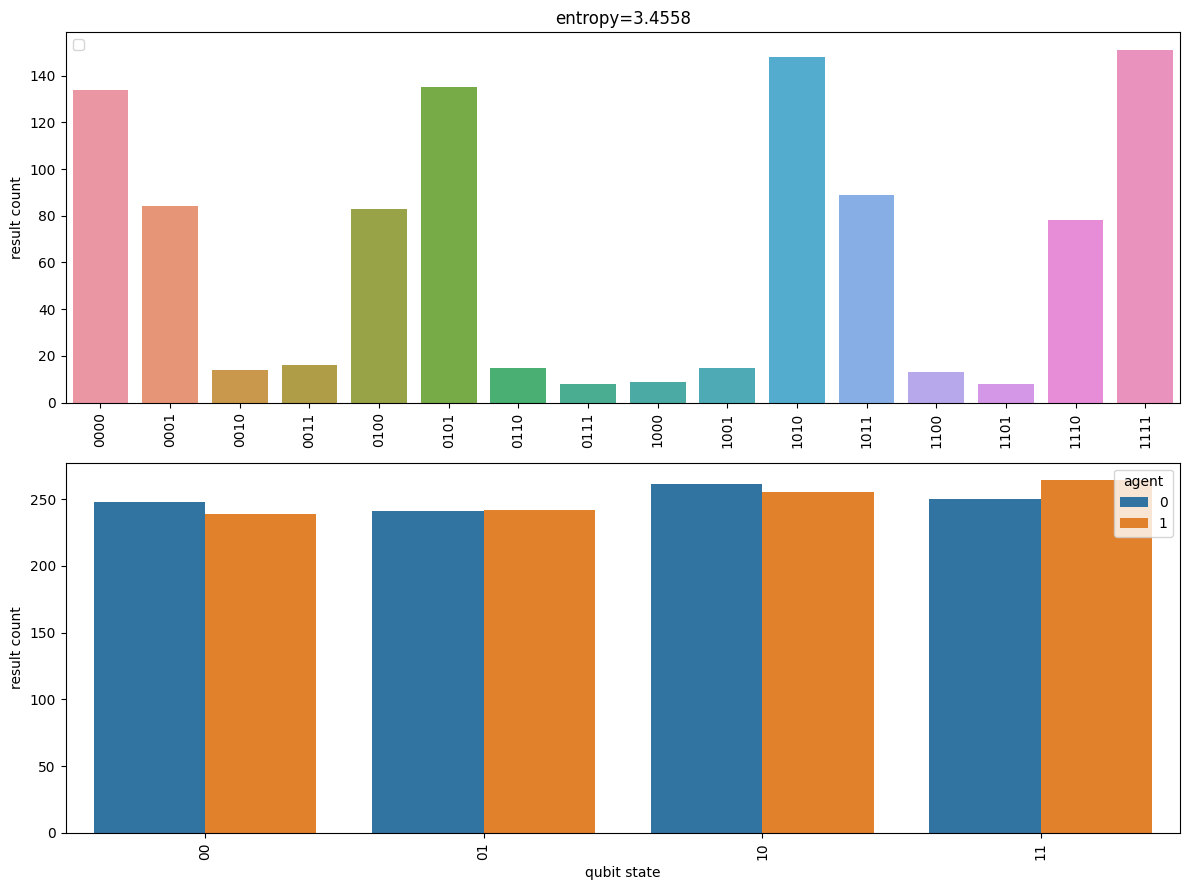

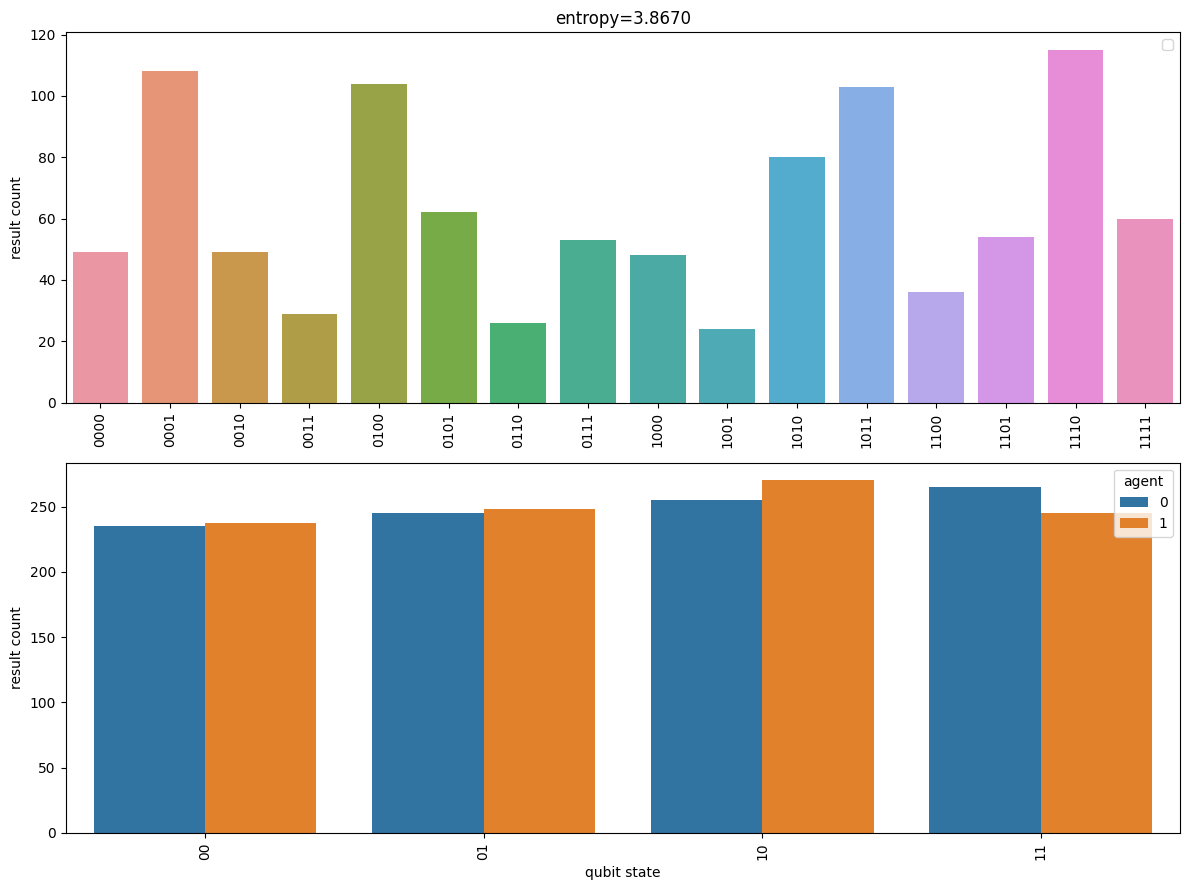

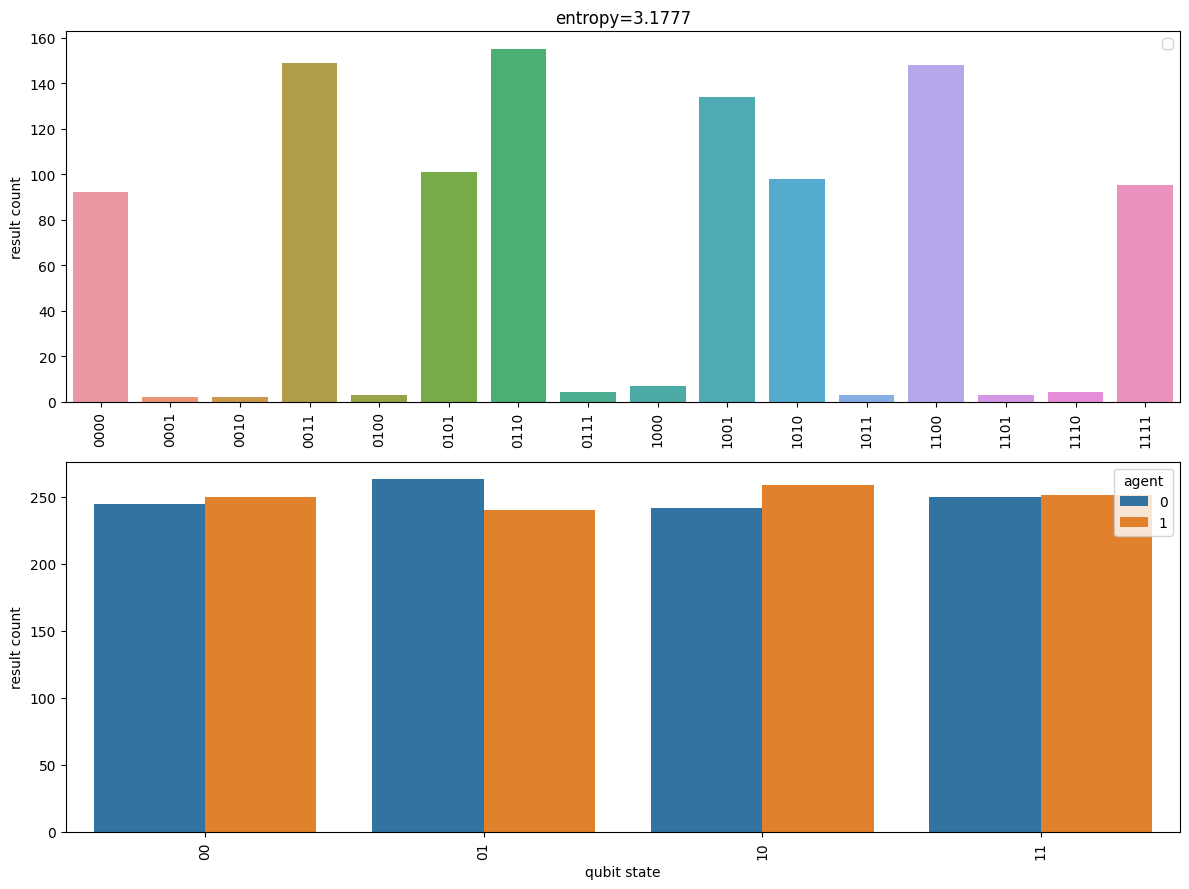

In [117]:
for _ in range(5):
    test(d_qubits, n_agents, repetitions=1000);